In [1]:
!pip install networkx
!pip install pandas
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np

In [2]:

nodes = pd.read_csv("data/glasgow_nodes.csv")
nodes['id'] = nodes.index + 1
nodes = nodes.dropna(subset=["age"]) # remove missing entry

edges = pd.read_csv("data/glasgow_edges.csv")
nodes['uses_tobacco'] = (nodes['tobacco_fct'] != 'Never').map({True: 'Yes', False: 'No'})

G = nx.from_pandas_edgelist(edges, source="from", target="to", create_using=nx.DiGraph())
G.remove_edges_from(nx.selfloop_edges(G))
G = G.subgraph(nodes["id"]).copy()

A = nx.to_numpy_array(G)

In [3]:
pos = nx.kamada_kawai_layout(G)

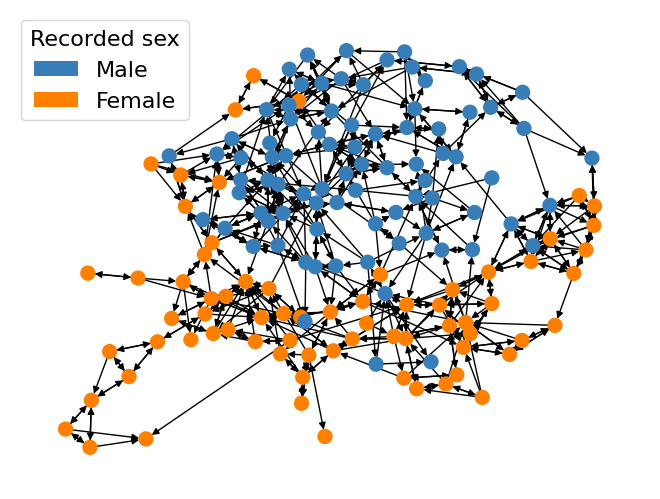

In [4]:
# Color nodes by 'sex_fct' column
color_map = {'Male': "#377eb8", "Female": "#ff7f00"}

node_colors = [color_map[nodes.loc[node - 1, 'sex_fct']] for node in G.nodes()]
nx.draw(G, pos, with_labels=False, node_size=100, arrows=True, arrowstyle='-|>', node_color=node_colors)

legend_elements = [Patch(facecolor = val, label = key) for key, val in color_map.items()]
plt.legend(handles=legend_elements, title="Recorded sex", loc="upper left", fontsize=16, title_fontsize=16)

plt.savefig("figures/glasgow_network_sex.png", dpi=300, bbox_inches='tight')
plt.show()

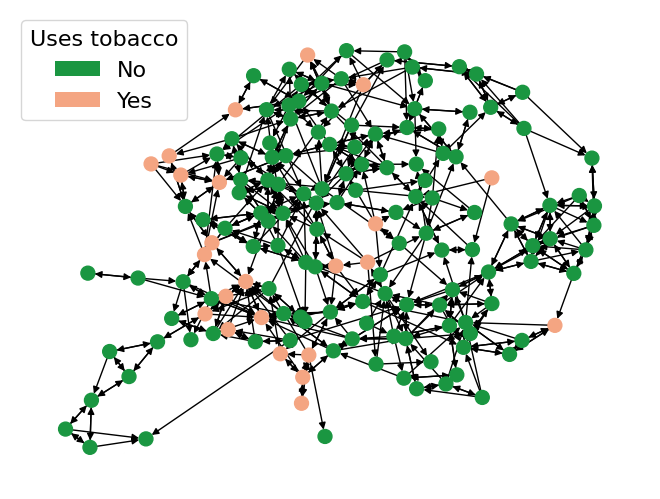

In [5]:
# Color nodes by 'sex_fct' column
# color_map = {'Never': '#1a9641', 'Occasional': '#f4a582', 'Regular': '#ca0020'}
color_map = {'No': '#1a9641', 'Yes': '#f4a582'}

node_colors = [color_map[nodes.loc[node - 1, 'uses_tobacco']] for node in G.nodes()]
nx.draw(G, pos, with_labels=False, node_size=100, arrows=True, arrowstyle='-|>', node_color=node_colors)

legend_elements = [Patch(facecolor = val, label = key) for key, val in color_map.items()]
plt.legend(handles=legend_elements, title="Uses tobacco", loc="upper left", fontsize=16, title_fontsize=16)

plt.savefig("figures/glasgow_network_tobacco.png", dpi=300, bbox_inches='tight')
plt.show()

In [6]:
# binarize tobacco usage outcome
Y = nodes['tobacco_fct'].map({'Never': 0, 'Occasional': 1, 'Regular': 2}).values
Y = (Y > 0).astype(int)

# encode network structure
U, S, V = np.linalg.svd(A)

# create features
X = np.hstack([
    np.ones(shape=(nodes.shape[0], 1)),
    nodes['sex_fct'].replace({'Female': 0, 'Male': 1}).values.reshape(-1, 1),
    pd.get_dummies(nodes['leisure_church'], drop_first=True, dtype=int).values,
    nodes['age'].values.reshape(-1, 1),
    U[:, :25],
    V.T[:, :25],
])

print(X.shape)

(152, 56)


/var/folders/sd/v_dt5vp17z75wd22155dfr880000gn/T/ipykernel_66260/3009519255.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  nodes['sex_fct'].replace({'Female': 0, 'Male': 1}).values.reshape(-1, 1),


In [314]:
# without network
from m_estimation_SI import GLM
family = "logistic"
level = 0.95

model = GLM(family=family, intercept=False).fit(X[:, :6], Y)
beta_est = model.beta_ # / scale[sel]  # rescale coefficients
conf_int = model.conf_int(X[:, :6], level=level) # / scale[sel].reshape(-1, 1)

print(np.exp(beta_est[1]))
print(np.exp(conf_int[1]))

0.2993161978796085
[0.11046681 0.81101449]


In [ ]:
# hyperparameters
n, p = X.shape
family = "logistic"
lam = 0.02
penalty = lam * np.sqrt(2 * np.log(p) / n) * np.std(Y)
level = 0.95
weights = [0] * (p - 50) + [1] * 50  # penalize only the network features

# scale columns
scale = np.linalg.norm(X, axis=0)

glm_noise = GLM(
        family=family,
        intercept=False,
).fit(X, Y)

Y_var_noise = glm_noise.get_var(X, Y)

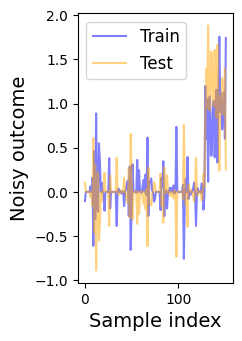

In [304]:
# draw noise
np.random.seed(0)
W = np.random.normal(0, 1, size=n)
W *= np.sqrt(Y_var_noise)

# noise the outcomes
gamma = 1
Y_train = Y + W * gamma
Y_test = Y - W / gamma

idx = np.argsort(Y)
plt.figure(figsize=(2, 3.5))
plt.plot(np.arange(n), Y_train[idx], label="Train", color='blue', alpha=0.5)
plt.plot(np.arange(n), Y_test[idx], label="Test", color='orange', alpha=0.5)
plt.legend(fontsize=12)
plt.xlabel("Sample index", fontsize=14)
plt.ylabel("Noisy outcome", fontsize=14)
plt.savefig("figures/glasgow_noisy_outcomes.png", dpi=300, bbox_inches='tight')
plt.show()

In [280]:
# selection on the training data
glm_sel = GLM(family=family, l1_penalty=penalty, intercept=False, weights=weights).fit(X, Y_train)
sel = glm_sel.active()

print("Selected left embedding features:", sel[np.where((sel > 5 )& (sel < 31))] - 5)
print("Selected right embedding features:", sel[sel > 30] - 30)

Selected left embedding features: [ 1  2  8  9 15 16 17 20 21 25]
Selected right embedding features: [ 6  9 10 12 13 14 25]


In [ ]:
# inference on the selected features
X_sel = X[:, sel]
model = GLM(family=family, intercept=False).fit(X_sel, Y_test)
beta_est = model.beta_ # / scale[sel]  # rescale coefficients
conf_int = model.conf_int(X_sel, level=level) # / scale[sel].reshape(-1, 1)

In [311]:
print(np.exp(beta_est[1]))
print(np.exp(conf_int[1]))

0.43378681135995695
[0.06045034 3.11281965]
